# Diarmuid Finnan - 13362201

This notebook makes use of the Near Earth Object (NEO) API managed by NASA

The comments in the markdown cells are relavent the given period (2018-01-01 -> 2018-01-08) but the script should work for any past time period with the max length being a week

In [1]:
import urllib 
import pandas as pd
import json as js
import time
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline

## Retrieve Data and Save to file

The link requires an API key and start and end dates. The maximum period is a week.

The data is returned in JSON. This is then saved locally with a timestamp as the filename

In [2]:
NASAkey = "OrJrtGnfDlYD7XTtz0wDsEM6xnXNrYvg0GG96sLQ"

start_year = "2018"
start_month = "01"
start_day = "01"

end_year = "2018"
end_month = "01"
end_day = "08"

link = "https://api.nasa.gov/neo/rest/v1/feed?start_date="+start_year+"-"+start_month+"-"+start_day+"&end_date="+end_year+"-"+end_month+"-"+end_day+"&api_key="+NASAkey
# Bad link example for testing
badlink = "https://api.nasa.gov/neo/rest/v1/feed?start_date=jk-01-01&api_key="+NASAkey

try:
    response = urllib.request.urlopen(link)
# If there's something wrong with the link
except urllib.error.URLError as e:
    print(e.reason)
    print("Error in getting data from API.\nCheck link.")
    
# If the link is ok
else:
    # Parse to json
    json = response.read().decode()
    # Create file for data
    timestr = time.strftime("%Y%m%d-%H%M%S")
    filename = "NASANEO"+timestr+".json"
    f = open(filename,"w")
    f.write(json)
    f.close

## Load data and make Python readable

The saved file is now accessed and loaded so that it can be easily interpretted by Python

In [3]:
data_raw = open(filename,"r")
contents = data_raw.read()
# Python readable
data = js.loads(contents)

print(data)

{'links': {'next': 'https://api.nasa.gov/neo/rest/v1/feed?start_date=2018-01-08&end_date=2018-01-15&detailed=false&api_key=OrJrtGnfDlYD7XTtz0wDsEM6xnXNrYvg0GG96sLQ', 'prev': 'https://api.nasa.gov/neo/rest/v1/feed?start_date=2017-12-25&end_date=2018-01-01&detailed=false&api_key=OrJrtGnfDlYD7XTtz0wDsEM6xnXNrYvg0GG96sLQ', 'self': 'https://api.nasa.gov/neo/rest/v1/feed?start_date=2018-01-01&end_date=2018-01-08&detailed=false&api_key=OrJrtGnfDlYD7XTtz0wDsEM6xnXNrYvg0GG96sLQ'}, 'element_count': 82, 'near_earth_objects': {'2018-01-04': [{'links': {'self': 'https://api.nasa.gov/neo/rest/v1/neo/2439898?api_key=OrJrtGnfDlYD7XTtz0wDsEM6xnXNrYvg0GG96sLQ'}, 'neo_reference_id': '2439898', 'name': '439898 (2000 TG2)', 'nasa_jpl_url': 'http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=2439898', 'absolute_magnitude_h': 19.9, 'estimated_diameter': {'kilometers': {'estimated_diameter_min': 0.2783267681, 'estimated_diameter_max': 0.6223575734}, 'meters': {'estimated_diameter_min': 278.3267680719, 'estimated_diameter_

The API returns json data from the time period the user specifies.

There are three primary elements in the data.

The first is a dictionary of links. These point towards, the next and previous time periods as well as the one specified by the user. As you can only request one week per call, having the following week as an argument makes it easier to make multiple calls of consecutive time periods allowing for larger datasets.

In [4]:
data["links"]

{'next': 'https://api.nasa.gov/neo/rest/v1/feed?start_date=2018-01-08&end_date=2018-01-15&detailed=false&api_key=OrJrtGnfDlYD7XTtz0wDsEM6xnXNrYvg0GG96sLQ',
 'prev': 'https://api.nasa.gov/neo/rest/v1/feed?start_date=2017-12-25&end_date=2018-01-01&detailed=false&api_key=OrJrtGnfDlYD7XTtz0wDsEM6xnXNrYvg0GG96sLQ',
 'self': 'https://api.nasa.gov/neo/rest/v1/feed?start_date=2018-01-01&end_date=2018-01-08&detailed=false&api_key=OrJrtGnfDlYD7XTtz0wDsEM6xnXNrYvg0GG96sLQ'}

The second is a count of the number of asteroids in this data set

In [6]:
num_obj = data["element_count"]
print(num_obj)

82


The third is the data on the objects

In [7]:
objinfo = data["near_earth_objects"]

## Display NEO information

Shown for one day

The "estimated diameter" and "close approach data" has been left out of this data frame as they are nested dictionaries with values in different units. This data will be returned to later

In [8]:
# List with date keys of objects withing objinfo
date_sets = sorted(objinfo.keys())

jsobj = js.dumps(objinfo[date_sets[0]])
pdobj = pd.read_json(jsobj)
# Select headings to display in table
short_pdobj = pdobj[["absolute_magnitude_h","is_potentially_hazardous_asteroid","name","nasa_jpl_url","neo_reference_id"]]
short_pdobj

,absolute_magnitude_h,is_potentially_hazardous_asteroid,name,nasa_jpl_url,neo_reference_id
0,18.9,False,189173 (2002 XY4),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=2189173,2189173
1,22.4,False,(2004 XK14),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=3263448,3263448
2,25.5,False,(2011 TP6),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=3581599,3581599
3,23.0,False,(2013 HO11),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=3635077,3635077
4,24.9,False,(2017 EB3),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=3771022,3771022
5,21.1,True,(2014 KT76),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=3672906,3672906
6,20.4,True,(2001 LD),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=3078262,3078262
7,25.5,False,(2017 YD),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=3792462,3792462
8,21.5,False,(2017 WY12),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=3789608,3789608
9,20.0,True,(2017 YR1),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=3794979,3794979


### Extract Other Useful Data
Values such as the miss distance are within nested dictionaries. Here they are accessed and saved to arrays for later use

In [9]:
# Create arrays to save data 
week_miss = []
size_max = []
size_min = []
appearance_arr = []
hazard_val = []

# Loop to attain data
# Cycle through each days set getting data then move to following day
for day in date_sets:
    chosen_day = objinfo[day]
    for val in chosen_day:
        howclose = val["close_approach_data"]
        misskm = float(howclose[0]["miss_distance"]["kilometers"])
        week_miss.append(misskm)

        size = val["estimated_diameter"]["kilometers"]
        max_km = float(size["estimated_diameter_max"])
        size_max.append(max_km)
        min_km = float(size["estimated_diameter_min"])
        size_min.append(min_km)

        appearance = float(val["absolute_magnitude_h"])
        appearance_arr.append(appearance)
        
        threat = val["is_potentially_hazardous_asteroid"]
        hazard_val.append(threat)

### Miss Distance

In [10]:
# Look at accessing one value for miss distance
day = objinfo[date_sets[0]]
howclose = day[0]['close_approach_data']

misskm = float(howclose[0]["miss_distance"]["kilometers"])
misskm

39365160.0

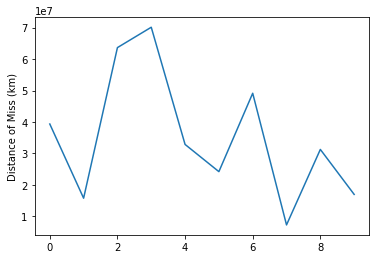

In [11]:
# Look at miss distance for one day
misskm_arr = []

for val in day:
    howclose = val["close_approach_data"]
    misskm = float(howclose[0]["miss_distance"]["kilometers"])
    misskm_arr.append(misskm)
    
x = range(0,len(misskm_arr),1)
plt.plot(x,misskm_arr)
plt.ylabel("Distance of Miss (km)")
plt.show()

Plot data for entire time period

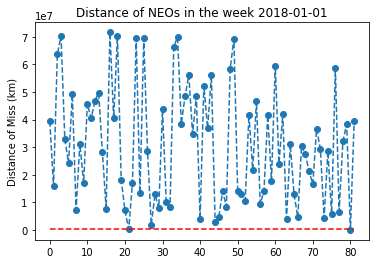

DescribeResult(nobs=82, minmax=(16890.947265625, 71637128.0), mean=30663200.585484948, variance=451335221997543.31, skewness=0.37910531113671786, kurtosis=-1.0022827456638368)

In [12]:
# Array the size of the data to plot against
x_new = range(0,len(week_miss),1)
  
# Moon distance = 384400km, for comparison
moon_dist = [384400]*len(x_new)
        
plt.plot(x_new,week_miss,'o--')
plt.plot(x_new,moon_dist,'r--')
plt.title("Distance of NEOs in the week "+min(date_sets))
plt.ylabel("Distance of Miss (km)")
plt.show()

stats.describe(week_miss)

The above graph shows the distance of objects from the earth in the given week. The closest object came to a distance less than 17,000 km. This distance is usually considered a medium earth orbit and is where many GPS satellites are situated. The most distant in this set was over 71 million km away, nearly 200 times more distant than the moon. 

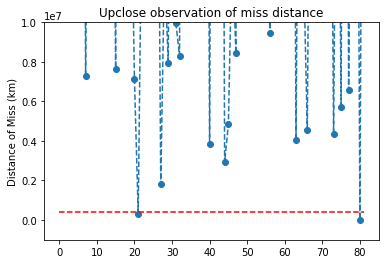

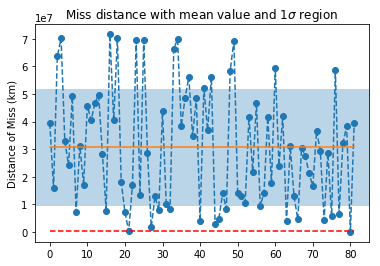

In [13]:
plt.plot(x_new,week_miss,'o--')
plt.plot(x_new,moon_dist,'r--')
plt.ylim(-1000000,10000000)
plt.title("Upclose observation of miss distance")
plt.ylabel("Distance of Miss (km)")
plt.show()

# Find mean and standard deviation of miss distance set
mean_miss = [np.mean(week_miss)]*len(x_new)
stdd_miss = [np.std(week_miss)]*len(x_new)

plt.plot(x_new,week_miss,'o--')
plt.plot(x_new,moon_dist,'r--')
plt.plot(x_new,mean_miss)
plt.axhspan(mean_miss[0]-stdd_miss[0],mean_miss[0]+stdd_miss[0],alpha=0.3)
plt.title("Miss distance with mean value and 1$\sigma$ region")
plt.ylabel("Distance of Miss (km)")
plt.show()

The top graph has a red line included to indicate the distance to the moon. By examining the points up close we can see only two asteroids passed within the orbit of the moon during this period. 

The bottom graph has an orange line indicating the mean distance of the asteroids as well as the region of one standard deviation either side.

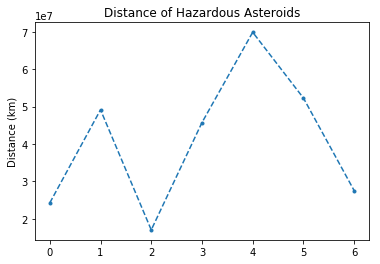

In [20]:
# Look at asteroids in set which are considered hazardous
hazards = []

for day in date_sets:
    chosen_day = objinfo[day]
    for val in chosen_day:
        scarey = val["is_potentially_hazardous_asteroid"]
        if scarey == True:
            scarey_dist = float(val["close_approach_data"][0]["miss_distance"]["kilometers"])
            hazards.append(scarey_dist)
            
            
x_haz = range(0,len(hazards),1)
plt.plot(x_haz,hazards,'.--')
plt.title("Distance of Hazardous Asteroids")
plt.ylabel("Distance (km)")
plt.show()

I had initially thought that hazardous was stritly related to close approach distance. However the above graph show's that even asteroids as far as 70 million km are considered hazardous. There is obviously another factor involved. Perhaps looking over all values would provide an insight into the designations. This will be done following the object size section

### Object Size

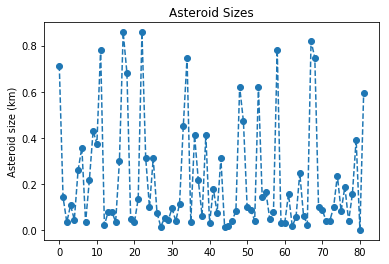

In [15]:
mean_size = np.mean([size_max,size_min],axis=0)

plt.plot(x_new,mean_size,'o--')
plt.title("Asteroid Sizes")
plt.ylabel("Asteroid size (km)")
plt.show()

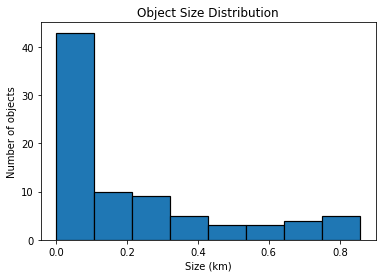

In [16]:
plt.hist(mean_size,bins="auto",edgecolor='black', linewidth=1.2)
plt.title("Object Size Distribution")
plt.xlabel("Size (km)")
plt.ylabel("Number of objects")
plt.show()

The size distribtuion histogram indicates about 50% of the objects are small (~0.1km). This large portion being very small is not unexpected for a population like this and one would think it would follow a Poisson distribution. The sharp fall off and rise towards the larger sizes is unexpected. This could perhaps indicate a preferance for objects to not have sizes around 0.5km. The trend could also be explained by the small sample size.

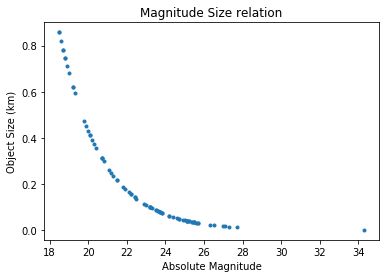

In [17]:
# Plot the absolute magnitude of the asteroid against the size
plt.plot(appearance_arr,mean_size,'.')
plt.title("Magnitude Size relation")
plt.xlabel("Absolute Magnitude")
plt.ylabel("Object Size (km)")
plt.show()

Plotting the absolute magnitude against the object size shows a very clear relationship which is expected as the brightness of the object would be used to help determine the object size.

The fit parameters are: a = 4300.73434299 b= 0.46051701861


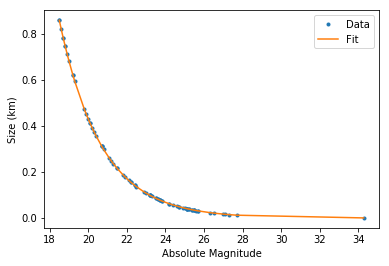

In [18]:
# The above curve appears to be an exponential decay 
# Using the curve_fit function a fit can give an equation of this plot

appearance_arr = np.array(appearance_arr)
mean_size = np.array(mean_size)

# Fix ordering
order = np.argsort(appearance_arr)
x_a = np.array(appearance_arr)[order]
y_x = np.array(mean_size)[order]

# Define an exponential function
def exp_f(x,a,b):
    return a*np.exp(-b*x)

# The optimal fit parameters and covariance information
popt,pcov = curve_fit(exp_f,x_a,y_x,p0=[430,0.4])
print("The fit parameters are: a =",popt[0],"b=",popt[1])

plt.plot(appearance_arr,mean_size,'.',label="Data")
plt.plot(x_a,exp_f(x_a,*popt),label="Fit")
plt.xlabel("Absolute Magnitude")
plt.ylabel("Size (km)")
plt.legend()
plt.show()

Curve_fit has showed that the equation to fit this graph is: y = $4300.73e^{-0.461x}$


Displaying relavant fields in a Pandas dataframe should allow for inspection. Sorting from closest approach asteroids seems to be a good place as I still feel the proximity is related to the threat level.

In [19]:
# Display full table, don't hide rows
pd.set_option('display.max_rows', 100)

mydf = pd.DataFrame(data={"is_potentially_hazardous_asteroid":hazard_val,"absolute_magnitude":appearance_arr,"miss_distance_km":week_miss,"size_km":mean_size,})
mydf.sort_values(by="miss_distance_km")

,absolute_magnitude,is_potentially_hazardous_asteroid,miss_distance_km,size_km
80,34.282,False,1.689095e+04,0.000599
21,22.500,False,2.969859e+05,0.136001
27,27.300,False,1.818718e+06,0.014912
44,27.700,False,2.913422e+06,0.012403
40,25.700,False,3.863864e+06,0.031156
63,24.400,False,4.065345e+06,0.056695
73,23.200,False,4.344456e+06,0.098524
66,26.300,False,4.539444e+06,0.023634
45,27.000,False,4.846018e+06,0.017122
75,23.600,False,5.727070e+06,0.081949


From inspection all hazardous asteroids have magnitudes less than 22 but this clearly isn't the qualifying factor as there are ones present with mag less than 22 which are not considered hazardous. A quick google told me it is related to the magnitude and minimum orbit intersection distance (MOID). This is obviously a different figure to the miss distance (possibly related to the inclination of the orbit) and not present in this data set

Further work which could be done with this set would be sourcing the MOID data and qualifying how an object is considered hazardous. 

Using the links to cycle through several weeks and examine the occurances over say a year could lead to cleare insights.